In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as ptf
from PIL import Image
%matplotlib inline

# Wonderful Minifloats

---------------------------------------------------

Today I wanna talk about training deep neural networks for low performance devices. A common way to speed up neural nets is quantization. There are two main types of quantization: 

1. FP16 (16-bit floating point) quantization - the boring one. It leaves you enough precision to work with in general. Most modern deep learning frameworks support FP16 through some sort of mixed precision training where FP16 and FP32 operations are interleaved to ensure better numerical stability. FP16 numbers are supported by many hardware platforms nowadays, and op compatibility in Pytorch/TensorFlow is also good, which is nice, because you can do inference completely inside FP16 and have all the speed benefits. But it is only twice as compact as regular FP32, and we always want more.
2. INT8 (8-bit fixed-point quantization) - the more funky one. It is also supported by main deep learning frameworks but has limited hardware support even as of today. Often the list of compatible ops is quite short which leads to either crashes or INT8-FP32 ops interleaving which kills all the performance gains. It is often used only for storage. But when your model is fully compatible - then it delivers! 

Besides these mainstream methods there is an obscure area of low-precision floating point computation. You see, floating point numbers are great for deep learning: they have smaller absolute error near zero, where most of the neural network parameters happen to be, and they also have a lot of range so dot products do not overflow. This is a really good trade off, whereas with INT8 you have either range or precision and nothing in between. You can use some finicky schemes like quantile encoding, sure. But I know you want to never leave that 8-bit wonderland and keep *all* computation in a low-precision format. Because this is where that sweet juicy performance™ really lies - cut the FP32 middleman! So the natural question arises: can we go beyond 16-bit floats? What about FP8? FP4 anyone?

There are plenty of excellent sources about floating point numbers in general.
1. [FP arithmetic](https://en.wikipedia.org/wiki/Floating-point_arithmetic) wiki
3. [FP16 specification](https://en.wikipedia.org/wiki/Half-precision_floating-point_format) wiki
2. Great [Jan Masali's video](https://www.youtube.com/watch?v=dQhj5RGtag0) on FP numbers and IEEE 754 standard

It is advised to be familiar with IEEE 754 format, distribution of FP numbers, absolute/relative errors, normal vs. subnormal numbers, overflow and underflow. But I will be covering these topics briefly anyway. Let's begin.

# Customizing IEEE 754

IEEE 754 standard has specifications for half, single, double and some higher precision FP number formats. All of them have three components - sign bit (S), exponent (E), mantissa (M) - and are stored like this:

```
S EEE...E  MMM...M
 └── Nₑ ─┘└── Nₘ ─┘ 

```

For example, a single precision (FP32) number is stored in 32 bits with 8 bits for the exponent and 23 bits for mantissa. The half precision (FP16) number has 5 exponent bits and 10 mantissa bits which totals to 16 bits (with 1 sign bit). Going from 32 to 16 bits drastically reduces precision and range of the number - but the factor of about 2<sup>112</sup>. 

The IEEE 754 representation can thus be parametrized by three numbers $(N_E, N_M, B)$ - length of the exponent in bits, length of the mantissa and the exponent bias, $N_E + N_M = \text{const}$. By changing these parameters we can exchange precision for range. If we plot the absolute representation error of floating point numbers we get a picture like this:

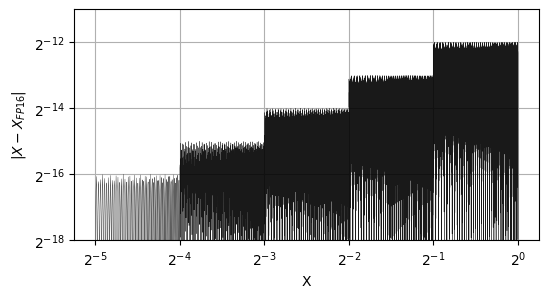

In [2]:
x = torch.linspace(2**(-5), 1, 10000, dtype = torch.double)
y = x.half().float()

plt.figure(figsize = (6,3))
plt.loglog(x, (x - y).abs(), 'k-', lw = 0.25, base = 2, alpha = 0.9)
plt.ylim(2**(-18), 2**(-11))
plt.xlabel('X')
plt.ylabel('$|X - X_{FP16}|$')
plt.grid()

The number line is split into $2^{E}$ intervals, each one twice as big. Each interval contains $2^M$ equally spaced numbers, therefore absolute error doubles for larger exponents, hence the steps on the graph. Having less mantissa bits halves the number of points per interval and doubles the error. Having less exponent bits halves the number of intervals and reduces the range. Exponent bias redistributes the intervals: larger bias means more intervals below 1 and vice versa. We'll get to the implications of this in a minute.

IEEE 754 provides kinda balanced parameters for all FP formats. For example, bias is always chosen to be $B = 2^{E-1} - 1$ which gives us an equal range below and above 1. The size of the mantissa also follows a nice power law:

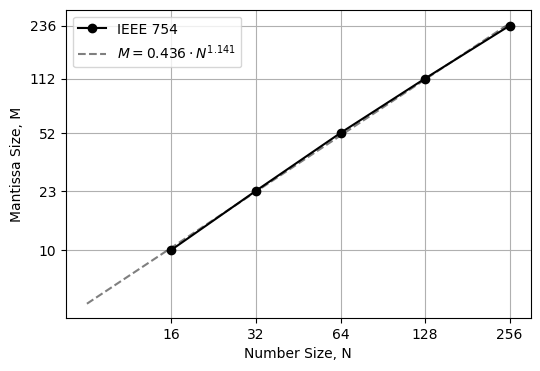

In [3]:
N = np.array([16, 32, 64, 128, 256])
M = np.array([10, 23, 52, 112, 236])
E = np.array([ 5,  8, 11,  15,  19])
t = np.arange(8, 256)

(a, b), _, _, _ = np.linalg.lstsq(np.stack([np.log2(N), np.ones(5)]).T, np.log2(M), rcond = None)

def ieee754_mantissa(size):
    return 2**(1.1405*np.log2(size) - 1.1959)

plt.figure(figsize = (6,4))
plt.plot(np.log2(N), np.log2(M), 'ko-', label = 'IEEE 754')
plt.plot(np.log2(t), a*np.log2(t) + b, 'k--', alpha = 0.5, label = f"$M = {2**b:.3f} \cdot N^{{{a:.3f}}}$")
plt.xlabel('Number Size, N')
plt.ylabel('Mantissa Size, M')
plt.xticks(np.log2(N), N);
plt.yticks(np.log2(M), M);
plt.legend()
plt.grid()

For our custom FP format we can also choose to either keep or discard subnormals. Subnormals were introduced into IEEE 754 to prevent underflow. They evenly fill the space between 0 and the smallest normal number and thus have the same absolute error. However, not every chip supports them. We can also get extra range for normal numbers by removing subnormals, but there better be a good reason for that.

Finally, there's also representation for ±infinity and NaNs in IEEE 754. Yeah, you read it right: NaNs. There is not one but $2^M - 1$ NaNs which is super wasteful when you have just a handful of bits to work with. The largest normal number has exponent $2^{E} - B - 1$. For FP16, for example, this corresponds to 15 or a bit sequence `11110`. The largest exponent value is reserved for infinities and NaNs. Positive/negative infinity has exponent $2^{E} - B$ and zero mantissa while NaNs have non-zero mantissas to store information about the cause of a NaN. Instead we can use this last exponent value to give us twice the range. To handle overflow in this case we can just clip the value.

These are essentially all our choices regarding customization of a FP number format besides actual bit arrangements. Different hardware platforms support either big- or little-endian formats or both. Endianness also depends on a compiler. I will provide big-endian examples for better readability.

Let's look at some examples. I will be using FP(M,E,B) notation to specify a particular choice of mantissa/exponent size and bias. There's no sense to consider FP(M,0,B) numbers, as they are essentially fixed-point formats. FP(0,E,B) is a set of exponentially spaced numbers which can have some practical implications. I'll also omit cases with NaNs/infinities as they are too wasteful and keeping them just reduces the range by half. Negative numbers are assumed by default, so I'll drop them as well. Subnormals are important, however. 

> **Example 1: FP2.** This is a degenerate case. We have FP(0,1,0) and FP(1,0,0) but both of them produce a ternary number which can be achieved using integers just fine, so FP2 is kinda useless.
>
> --------------------------
>
> **Example 2: FP3.** FP(1,1,1) is the smallest non-trivial FP format. It can either include subnormals or not. Let's take a look at these two cases. Additionally, let's take a look at FP(0,2,2):

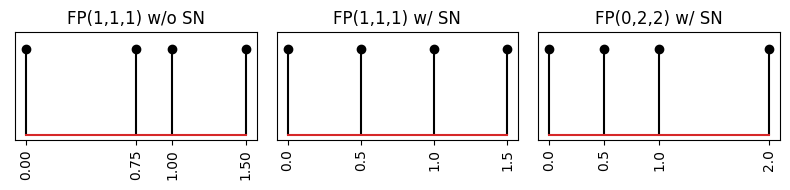

In [4]:
plt.figure(figsize = (8,2))

plt.subplot(1,3,1)
x = [0, 0.75, 1, 1.5]
plt.title("FP(1,1,1) w/o SN")
plt.stem(x, np.ones(len(x)), 'k-')
plt.ylim(-0.05, 1.2)
plt.xticks(x, rotation = 90)
plt.yticks([], [])

plt.subplot(1,3,2)
x = [0, 0.5, 1, 1.5]
plt.title("FP(1,1,1) w/ SN")
plt.stem(x, np.ones(len(x)), 'k-')
plt.ylim(-0.05, 1.2)
plt.xticks(x, rotation = 90)
plt.yticks([], [])

plt.subplot(1,3,3)
x = [0, 0.5, 1, 2]
plt.title("FP(0,2,2) w/ SN")
plt.stem(x, np.ones(len(x)), 'k-')
plt.ylim(-0.05, 1.2)
plt.xticks(x, rotation = 90)
plt.yticks([], [])
plt.tight_layout()

> FP(1,1,1) appears to be practically useless. The first case has uneven lopsided distribution. The second case is just a fixed point number system. So out of the blue a number with *no mantissa* becomes the best choice for FP3. I should also note the effect of choosing a particular exponent bias. Bias changes multiplication tables. Let's compare multiplication tables for FP(1,1,1)  and FP(1,1,0) and look at the indices of resulting numbers:

| B = 1 | -1.5 | -1.0 | -0.75 | 0.0 | 0.75 | 1.0 | 1.5 | | B = 0 | -3.0 | -2.0 | -1.5 | 0.0 | 1.5 | 2.0 | 3.0 | 
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | - | -- | -- | -- | -- | -- | -- | -- | -- |
| **-1.5**  | 6 | 6 | 5 | 3 | 1 | 0 | 0 | | **-3.0** | 6 | 6 | 6 | 3 | 0 | 0 | 0 |
| **-1.0**  | 6 | 5 | 4 | 3 | 2 | 1 | 0 | | **-2.0** | 6 | 6 | 6 | 3 | 0 | 0 | 0 |
| **-0.75** | 5 | 4 | 4 | 3 | 2 | 2 | 1 | | **-1.5** | 6 | 6 | 5 | 3 | 1 | 0 | 0 |
| **0.0**   | 3 | 3 | 3 | 3 | 3 | 3 | 3 | | **0.0**  | 3 | 3 | 3 | 3 | 3 | 3 | 3 |
| **0.75**  | 1 | 2 | 2 | 3 | 4 | 4 | 5 | | **1.5**  | 0 | 0 | 1 | 3 | 5 | 6 | 6 |
| **1.0**   | 0 | 1 | 2 | 3 | 4 | 5 | 6 | | **2.0**  | 0 | 0 | 0 | 3 | 6 | 6 | 6 |
| **1.5**   | 0 | 0 | 1 | 3 | 5 | 6 | 6 | | **3.0**  | 0 | 0 | 0 | 3 | 6 | 6 | 6 |
 
> Smaller bias makes the overall scale of the numbers bigger and overflow happens much more often. For larger biases multiplication tables tend to concentrate near zero. You can check that for $B = 2$ yourself. So the choice of the bias matters and multiplication/addition tables are subject to a closer inspection when working with such low precision number systems.
>
> --------------------------
>
> **Example 3: FP4.** This is the first non-trivial format and also more practical one since two FP4 numbers can be packed into one byte. We have a couple of options here: FP(2,1,1) and FP(1,2,2). The bias is chosen such that there are 3 numbers above and below 1. Here's what they look like:

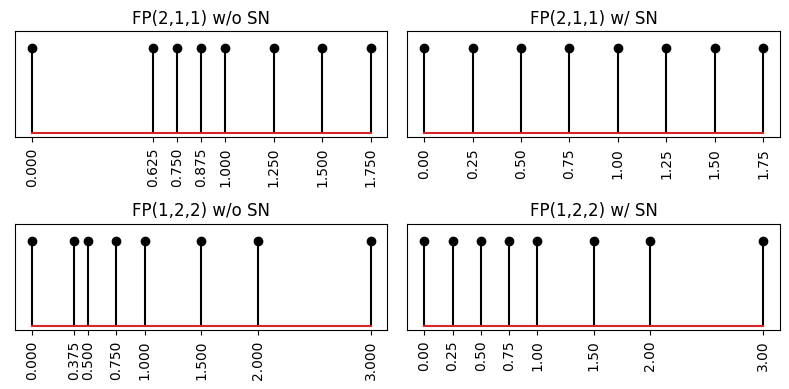

In [5]:
plt.figure(figsize = (8,4))

plt.subplot(2,2,1)
x = [0, 0.625, 0.75, 0.875, 1, 1.25, 1.5, 1.75]
plt.title("FP(2,1,1) w/o SN")
plt.stem(x, np.ones(len(x)), 'k-')
plt.xticks(x, rotation = 90)
plt.ylim(-0.05, 1.2)
plt.yticks([], [])

plt.subplot(2,2,2)
x = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75]
plt.title("FP(2,1,1) w/ SN")
plt.stem(x, np.ones(len(x)), 'k-')
plt.xticks(x, rotation = 90)
plt.ylim(-0.05, 1.2)
plt.yticks([], [])

plt.subplot(2,2,3)
x = [0, 0.375, 0.5, 0.75, 1, 1.5, 2, 3.0]
plt.title("FP(1,2,2) w/o SN")
plt.stem(x, np.ones(len(x)), 'k-')
plt.xticks(x, rotation = 90)
plt.ylim(-0.05, 1.2)
plt.yticks([], [])

plt.subplot(2,2,4)
x = [0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3.0]
plt.title("FP(1,2,2) w/ SN")
plt.stem(x, np.ones(len(x)), 'k-')
plt.xticks(x, rotation = 90)
plt.ylim(-0.05, 1.2)
plt.yticks([], [])

plt.tight_layout()

> Intuitively it may seem like FP(2,1,1) is a good number system, because mantissa is longer than the exponent, which is true for any standard FP number. Also our power law for mantissa size says it should be 2. But FP(2,1,1) with subnormals is just a fixed point number system and doesn't make much sense. FP(2,1,1) has very uneven number distribution with a big gap between 0 and the smallest number which is not very practical as well. And kinda unexpectedly FP(1,2,2) turned out to be a better choice for the FP4 format. So mantissa doesn't always need to be larger than the exponent.

# Simulating FP*n* Quantization

Hardware with proper support for such specific numbers isn't common. You should expect that you as a AI developer wouldn't have access to such device at training time. I personally had to develop models for specialized NPUs in a almost black-box way where we only had datasheets for the chip and haven't been able even to test the model on the chip ourselves, just to send it to a guy who managed the guy who had the access to the device and could run our tests. In such scenarios emulation is your only option. For that we can use the same method used to training INT8 models - fake quantization. So we need a fake quantizer for FPn, duh! Fake quantizer is just a fancy rounding function inserted before and/or after ops of interest. In our case it must be an FP rounding function and we can't just apply `round()` and call it a day. So let's create one.

We'll start with a prototype in pure Pytorch. It will be painfully slow but also much faster to create. Let's make it step by step. I am going to write it for `torch.float` (i.e. FP32) inputs because nobody really cares about double precision in deep learning anyway and changing it to `half` or `double` is a matter of tweaking a couple of constants. First, we need to quantize  the mantissa. Immediate idea which came to my mind is something like this:

In [6]:
# mantissa is in [0.5, 1] range except for 0
mantissa, exponent = torch.frexp(x)  

# scaling to a range [0, 2^M] so rounding to the
# nearest integer will produce 2^M values per exponent
scale_factor = 2**(M + 1)
scaled_mantissa = scale_factor * (mantissa - 0.5)

# quantization is done here
int_mantissa = torch.round(scaled_mantissa)

# scaling back
quantized_mantissa = int_mantissa / scale_factor + 0.5
x_quantized = torch.ldexp(quantized_mantissa, exponent)

TypeError: frexp(): argument 'input' (position 1) must be Tensor, not list

Second, we need to adjust the range. Upper limit can be just thresholded. Lower limit requires a bit more fiddling. If there's no subnormals, then everything below $2^{-B}$ is just rounded to zero. If you wanna be more accurate, the "correct" cutoff threshold is $2^{-B-1} (1 + 2^{-M})$. But for subnormals we must perform usual fixed-point quantization for all numbers below $2^{1-B}$. 

In [7]:
def fp_quantizer(x, M, E, B, use_subnormals = True, use_inf = False):
    # define some constants
    UNDERFLOW = 2**(-B - 1) * (1 + 2**(-M))
    NORMAL_MIN = 2**(1 - B)
    NORMAL_MAX = 2**(2**E - B - 1) * (1 - 2**(-M-1)) if use_inf else \
                 2**(2**E - B - 0) * (1 - 2**(-M-1)) 
    SUBNORMAL_STEP = 2**(1 - B - M)

    # mantissa is in [0.5, 1] range except for 0
    mantissa, exponent = torch.frexp(x)  

    # scaling to a range [0, 2^M-1]
    scale_factor = 2**(M+1)
    scaled_mantissa = scale_factor * (mantissa - 0.5)

    # quantization is done here
    int_mantissa = torch.round(scaled_mantissa)

    # scaling back
    quantized_mantissa = int_mantissa / scale_factor + 0.5
    x_quantized = torch.ldexp(quantized_mantissa, exponent)

    # dealing with subnormals
    if use_subnormals:
        subnormals = torch.round(x / SUBNORMAL_STEP) * SUBNORMAL_STEP
        x_quantized_subn = torch.where(x.abs() < NORMAL_MIN, subnormals, x_quantized)
    else:
        x_quantized_subn = torch.where(x.abs() < 2*UNDERFLOW, 2*UNDERFLOW * x.sign(), x_quantized)
        x_quantized_subn = torch.where(x.abs() < UNDERFLOW, 0, x_quantized_subn)

    # limit range
    q = torch.clamp(x_quantized_subn, min = -NORMAL_MAX, max = NORMAL_MAX)
    return q

This particular implementation is purely arithmetic and may not seem optimal in terms of performance considering the low-level nature of the problem. Another way to get the same result is to use bit masking. Lets recall how FP32 number is stored:

```SEEE EEEE EMMM MMMM MMMM MMMM MMMM MMMM```

Performing bitwise AND between FP32 float and a number:

```1111 1111 1111 1111 1111 0000 0000 0000```

as a bit mask discards 12 least-significant bits of the mantissa and is equivalent to `floor()` function. We need `round()`, however. To achieve that we need to offset the input number by $2^{E_x - M - 2}$ before masking, where $E_x$ is the exponent value of $x$ and $M$ is the target size of the mantissa. This offset corresponds to a half-width of the exponent interval $x$ should fall in. But (un)fortunately this change doesn't do much for the performance and I leave it to you to verify that. If you really need performance you should better write a custom CUDA kernel for it anyway, so I'll stick to the original "arithmetic" version of the quantizer. On my GPU it takes on average about half-nanosecond per number for decently large tensors.

This concludes our floating point quantizer. The graph of it is shown below:

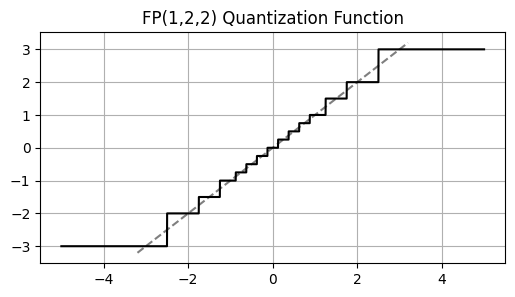

In [8]:
x = torch.linspace(-5, 5, 10001, dtype = torch.float)
q = fp_quantizer(x, M = 1, E = 2, B = 2, use_subnormals = True, use_inf = False)

plt.figure(figsize = (6,3))
plt.title('FP(1,2,2) Quantization Function')
plt.plot(x, q, 'k-')
plt.plot(x[1800:-1800], x[1800:-1800], 'k--', alpha = 0.5)
plt.grid()

A little sanity check. Let's compare this quantizer to some easily accessible low-precision FP format - FP16, which corresponds to FP(10, 5, 15) in our notation. They are indeed equal both near 0, near 1 and at "infinity":

In [9]:
print("FP16 Test (10⁵ points)")
print(f'Range             Max. Absolute Error')

x = torch.linspace(0.5, 2, 100001, dtype = torch.float)
fp16_ref = x.half().float()
fp16_q = fp_quantizer(x, M = 10, E = 5, B = 15)
print(f"[ 2e-01,  2e+01]:\t{(fp16_q - fp16_ref).abs().max()}")

x = torch.linspace(2**13, 65504, 100001, dtype = torch.float)
fp16_ref = x.half().float()
fp16_q = fp_quantizer(x, M = 10, E = 5, B = 15)
print(f"[ 2e+13,  2e+16]:\t{(fp16_q - fp16_ref).abs().max()}")

x = torch.linspace(-2**(-12), 2**(-12), 100001, dtype = torch.float)
fp16_ref = x.half().float()
fp16_q = fp_quantizer(x, M = 10, E = 5, B = 15)
print(f"[-2e-12, +2e-12]:\t{(fp16_q - fp16_ref).abs().max()}")

FP16 Test (10⁵ points)
Range             Max. Absolute Error
[ 2e-01,  2e+01]:	0.0
[ 2e+13,  2e+16]:	0.0
[-2e-12, +2e-12]:	0.0


# Practical Considerations

To perform end-to-end training our quantizer must be differentiable. The natural choice for the derivative is to pretend that it is an identity function at backward pass and has derivative of 1. Of course, the derivative of our quantization function is zero almost everywhere and not 1, strictly speaking. But the same is true for FP32 numbers as well: they also perform quantization but much more fine-grained so the discrepancy isn't really noticeable. 

> **Side thought.** This floating point quantization is present even for FP32. It introduces some noise into otherwise ideal analytical expressions. And the amplitude of this noise grows kinda linearly with the magnitude of the number because of the nature of floating point numbers: larger numbers are represented less precisely. Less noise at a smaller number means that more information is preserved there and it becomes a more preferable state for parameters of the model to be in. And this resembles some kind of regularization. Let's take a closer look. 
>
> Let $\varepsilon$ be i.i.d. random variable with mean $\mathbb{E}[\varepsilon] = 0$ and variance $\sigma^2$. Consider a following linear regression problem then:
>
> $$ \hat{y}_i = (x_i + x_i \varepsilon)^T w$$
>
> The term $x_i \varepsilon$ here simulates our floating point quantization noise, because $\text{std}(x_i \varepsilon) = x_i \sigma$ and grows linearly with $x_i$. Now let's write down a least-squares solution to this regression problem:
>
> $$ L(w) = \mathbb{E} \left[ \frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2 \right] 
    = \mathbb{E} \left[ \frac{1}{n} \sum_{i=1}^n \left( y_i - (x_i + x_i \varepsilon)^T w \right)^2 \right] \\
    = \mathbb{E} \left[ \frac{1}{n} \sum_{i=1}^n \left( \left( y_i - x_i^T w \right) - \varepsilon x_i^T w \right)^2 \right] $$
> 
> After expanding the square and moving expectation in we obtain:
>
> $$ L(w) = \frac{1}{n} \sum_{i=1}^n \left( y_i - x_i^T w \right)^2 + \sigma^2 w^T \mathbb{E} \left[ x_i x_i^T \right] w $$
> 
> We can make the matrix $\mathbb{E} \left[ x_i x_i^T \right]$ into an identity matrix by centering and whitening $x_i$. In this case we'd get:
>
> $$ L(w) = \frac{1}{n} \sum_{i=1}^n \left( y_i - x_i^T w \right)^2 + \sigma^2 \|w\|^2 $$
> 
> which is exactly the expression for $L_2$-regularized least squares with regularization strength $\lambda = \sigma^2$. This regularization is very weak however. Suppose a floating point number has M mantissa bits then $\lambda \sim 2^{-2(M+1)}$. Here are some values for different FP numbers:
>
> | Type       | $\lambda$         |
> |:-----------|:-----------------:|
> | FP32       | ~10<sup>-15</sup> |
> | FP16       | ~10<sup>-7</sup>  |
> | FP8(3,4,7) | 0.0039            |
> | FP4(1,2,2) | 0.0625            |
> 
> We can observe that this regularization due to quantization becomes significant even for FP16 and for less precise numbers it should definitely be accounted for. This is interesting on its own but let's get back to the derivatives.

But overflow becomes *very* prominent at such low precision, so a more accurate way of thinking about our quantizer is like HardTanh: it has derivative of 1 inside a linear region and 0 everywhere else. Doing so eliminates the discrepancy between forward and backward passes and reduces noise outside the linear region. There's a little subtlety about how to define this linear region. Earlier we found the maximum representable number as $2^{2^E - B} \cdot (1 - 2^{-M-1})$ (if infinity is omitted). However, the linear region of our quantizer should go a bit beyond that to cover the neighborhood of the largest number properly. Thus the derivative threshold should be just $2^{2^E - B}$. Putting it all together we get a `minifloat()` autograd function:

In [10]:
class minifloat(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x, M = 1, E = 2, B = 2, use_subnormals = True, use_inf = False):
        ctx.thresh = 2**(2**E - B)
        ctx.save_for_backward(x)
        return fp_quantizer(x, M, E, B, use_subnormals = use_subnormals, use_inf = use_inf)

    @staticmethod
    def backward(ctx, grad_output):
        inputs, = ctx.saved_tensors
        mask = inputs.abs() < ctx.thresh
        gx = mask * grad_output
        return gx, None, None, None, None, None

And here are its graphs:

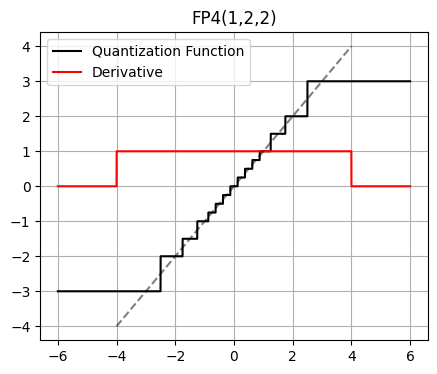

In [11]:
x = torch.nn.Parameter(torch.linspace(-6, 6, 6001))
y = minifloat.apply(x)
y.sum().backward()

plt.figure(figsize = (5,4))
plt.title('FP4(1,2,2)')
plt.plot(x.detach(), y.detach(), 'k-', label = 'Quantization Function')
plt.plot(x.detach(), x.grad.detach(), 'r-', label = 'Derivative')
plt.plot(x.detach()[1000:-1000], x.detach()[1000:-1000], 'k--', alpha = 0.5)
plt.legend()
plt.grid()

Second, don't repeat my mistakes and never do quantization-aware training like this:

In [12]:
def prehook(layer, inputs):
    layer.weight.data = minifloat.apply(layer.weight.data)
    layer.bias.data = minifloat.apply(layer.bias.data)
    for x in inputs:
        x.data = minifloat.apply(x.data)
    return inputs

for layer in quantized_layers:
    layer.register_forward_pre_hook(prehook)

NameError: name 'quantized_layers' is not defined

Fake quantizer must *never* be in-place or otherwise modify real weights! This prevents small backprop steps to accumulate and change a quantized value which in turn leads to total training standstill. 

Another important thing is initialization. Now with modern powerful hardware able to run big models in a overparameterized regime the problem of vanishing/exploding gradients is rarely observed. But low precision and limited range of minifloats bring it back in the **boldest** form possible! Our quantizer underflows and saturates easily. Without proper initialization training won't even start. Usual unit-variance initializers based on theoretical variance estimates, like He or Xavier, are too unstable - small deviations accumulate real fast. Sometimes they work, sometimes they don't. A more reliable way is to use an explicit iterative data-based procedure from [Mishkin (2015)](https://arxiv.org/pdf/1511.06422.pdf) or similar:

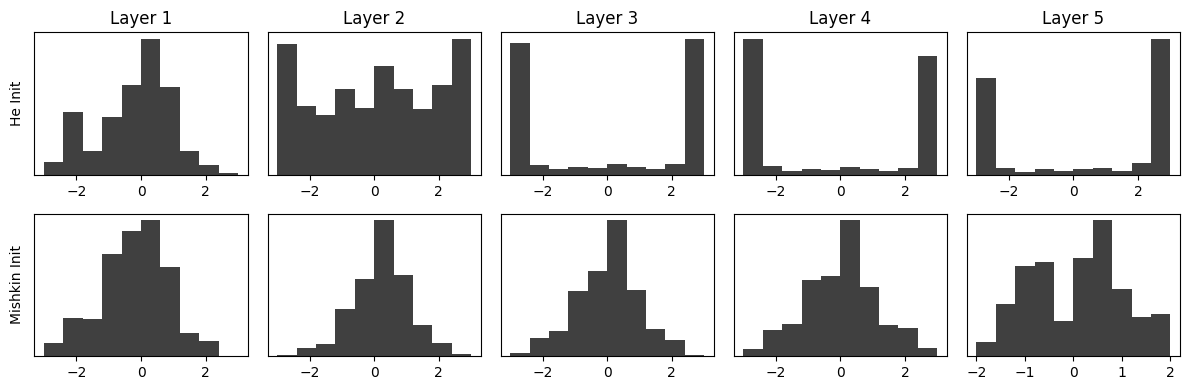

In [13]:
Image.open('init_cmp.png')

Sometimes He initializer diverges even at first layers while explicit variance scaling stays in line.

Finally, the limited range of a minifloat can become a problem when computing losses. Take our friend FP4(1,2,2), for example. The biggest number in FP4 is 3. If our activations are in FP4 this means that logits of the classifier are also limited to the range [-3,+3]. This creates a lower limit on the cross-entropy, because $-\log(\sigma(3)) \approx 0.049$. To allow cross-entropy to go all the way to 0 we need to add logit scaling during loss computation by some factor (about 4-5 for FP4). 

> **Side thought.** The same is actually true for any non-linear functions. ReLU is safe but only because it has only two regimes and is scale-invariant. Other functions like $\tanh$ may not saturate because of insufficient range of minifloat inputs. Activations like Swish and SELU most likely lose their properties as well not only because of small range but because of the too discrete nature of the inputs. This suggests that number systems like FP4 may require their own special activation functions. Considering that FP4 has only 15 representable numbers (besides -0.0), it may be faster and easier to just create lookup tables for such functions. 

These things alone (proper derivative, initialization, logit scaling and *not being dumb*) make it possible to reliably train a small convnet on MNIST (don't beat me too hard, it's just for tests) in FP4(1,2,2) - both inputs, weights and activations - to the test accuracy of 97% in 1000 iterations which is kinda remarkable in my opinion. FP8(3,4,7) pushes it to 99%. Isn't it neat? 

# Conclusion

Today we've peaked into an obscure area of low-precision floating point computation, generalized IEEE 754 format to arbitrary bit lengths and learned that at such extremes we should care even about things like multiplication tables. We've also created a minifloat quantizer for PyTorch and demonstrated that we can effectively train models in FP4. In a short detour we've also established a connection between floating point precision and $L_2$-regularization which is a fun little thing on its own. 

Unfortunately, our quantizer is still not a *true* minifloat arithmetic, and many operations are performed in FP32 under the hood. The *true* minifloat arithmetic would perform rounding at every operation which would change results as minifloats aren't closed under addition nor multiplication: 2 + 0.75 in FP4 is equal to 2.75 which is not in FP4 and must be rounded up to 3. This rounding doesn't occur in our simulations and we need either proper hardware for that or software emulation at low level. PyTorch isn't really a place for such shenanigans. Imagine how cool it would be to have a FP4 or at least FP8 backend for PyTorch! But this is a story for another time. It's too late already. Good night.

**P.S.** Just before I go, here's a nice paper about FP8 NPU chip design for you: [Phoenix: A Low-Precision Floating-Point Quantization Oriented Architecture for Convolutional Neural Networks](https://arxiv.org/pdf/2003.02628.pdf) 